In [0]:
import numpy as np
import pandas
import tensorflow as tf
import pylab as plt
import csv
import timeit

MAX_DOCUMENT_LENGTH = 100 
HIDDEN_SIZE = 20
MAX_LABEL = 15 
EMBEDDING_SIZE = 20

no_epochs = 300
batch_size = 128
lr = 0.01 

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

In [0]:
def word_rnn_model(x):

  word_vectors = tf.contrib.layers.embed_sequence(
      x, vocab_size=no_words, embed_dim=EMBEDDING_SIZE)

  word_list = tf.unstack(word_vectors, axis=1)

  cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
  _, encoding = tf.nn.static_rnn(cell, word_list, dtype=tf.float32)

  logits = tf.layers.dense(encoding, MAX_LABEL, activation=None)

  return logits, word_list

In [0]:
def data_read_words():
  
  x_train, y_train, x_test, y_test = [], [], [], []
  
  with open('train_medium.csv', encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_train.append(row[2])
      y_train.append(int(row[0]))

  with open("test_medium.csv", encoding='utf-8') as filex:
    reader = csv.reader(filex)
    for row in reader:
      x_test.append(row[2])
      y_test.append(int(row[0]))
  
  x_train = pandas.Series(x_train)
  y_train = pandas.Series(y_train)
  x_test = pandas.Series(x_test)
  y_test = pandas.Series(y_test)
  y_train = y_train.values
  y_test = y_test.values
  
  vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
      MAX_DOCUMENT_LENGTH)

  x_transform_train = vocab_processor.fit_transform(x_train)
  x_transform_test = vocab_processor.transform(x_test)

  x_train = np.array(list(x_transform_train))
  x_test = np.array(list(x_transform_test))

  no_words = len(vocab_processor.vocabulary_)
  print('Total words: %d' % no_words)

  return x_train, y_train, x_test, y_test, no_words

In [0]:
 
x_train, y_train, x_test, y_test, no_words = data_read_words()

# Create the model
x = tf.placeholder(tf.int64, [None, MAX_DOCUMENT_LENGTH])
y_ = tf.placeholder(tf.int64)

logits, word_list = word_rnn_model(x)

# Optimizer
entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), y_), tf.float64))
train_op = tf.train.AdamOptimizer(lr).minimize(entropy)

with tf.Session() as sess:
  start_time = timeit.default_timer()

  sess.run(tf.global_variables_initializer())

  training_entropy = []
  testing_accuracy = []

  N = len(x_train)
  idx_train = np.arange(N)

  for e in range(no_epochs):
    np.random.shuffle(idx_train)
    x_train = x_train[idx_train]
    y_train = y_train[idx_train]

    for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
      train_op.run(feed_dict={x: x_train[start:end], y_: y_train[start:end]})

    training_entropy.append(entropy.eval(feed_dict={x: x_train, y_: y_train}))
    testing_accuracy.append(accuracy.eval(feed_dict={x: x_test, y_: y_test}))

    if e%1 == 0:
      print('iter: %d, training entropy: %g'%(e, training_entropy[e]))
      print('iter: %d, testing accuracy: %g'%(e, testing_accuracy[e]))
      print()

  stop_time = timeit.default_timer()
  running_time = stop_time - start_time

Total words: 38658
iter: 0, training entropy: 2.15114
iter: 0, testing accuracy: 0.177143

iter: 1, training entropy: 1.56196
iter: 1, testing accuracy: 0.334286

iter: 2, training entropy: 1.03227
iter: 2, testing accuracy: 0.537143

iter: 3, training entropy: 0.494628
iter: 3, testing accuracy: 0.765714

iter: 4, training entropy: 0.260602
iter: 4, testing accuracy: 0.812857

iter: 5, training entropy: 0.102004
iter: 5, testing accuracy: 0.845714

iter: 6, training entropy: 0.0937306
iter: 6, testing accuracy: 0.824286

iter: 7, training entropy: 0.0844724
iter: 7, testing accuracy: 0.827143

iter: 8, training entropy: 0.0301662
iter: 8, testing accuracy: 0.84

iter: 9, training entropy: 0.0152201
iter: 9, testing accuracy: 0.848571

iter: 10, training entropy: 0.0116268
iter: 10, testing accuracy: 0.857143

iter: 11, training entropy: 0.00921338
iter: 11, testing accuracy: 0.854286

iter: 12, training entropy: 0.0102948
iter: 12, testing accuracy: 0.851429

iter: 13, training entrop

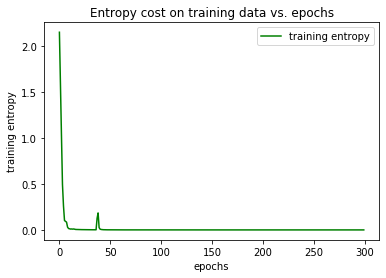

Running Time: 576.2670882979999


In [0]:
# plot learning curves
plt.figure()
plt.title('Entropy cost on training data vs. epochs')
plt.plot(range(no_epochs), training_entropy,'g',label = 'training entropy')
plt.xlabel('epochs')
plt.ylabel('training entropy')
plt.legend(loc='best')

plt.figure()
plt.title('Accuracy on testing data vs. epochs')
plt.plot(range(no_epochs), testing_accuracy,'r',label = 'testing accuracy')
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.legend(loc='best')

plt.show()

#Print running time
print("Running Time:", running_time)

In [0]:
np.save('Word RNN(GRU)_Training entropy without dropout',np.array(training_entropy))
np.save('Word RNN(GRU)_Testing accuracy without dropout',np.array(testing_accuracy))